# GMM Temperature Classification - Cold_normal vs Hot

This notebook implements:
- Loading sensor data from Readings/Cold_normal and Readings/Hot folders
- Using folder labels as ground truth
- Statistical feature engineering (mean, std, min, max, percentiles, etc.)
- Train-test split for evaluation
- GMM model training and evaluation
- Visualizations and performance metrics


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')
sns.set_palette("husl")
%matplotlib inline


## 1. Data Loading


In [19]:
def load_all_data(data_dir=None):
    """Load all sensor data from Cold_normal and Hot folders.
    Returns file-level data: each file becomes one data point with aggregated features."""
    # Auto-detect the correct path
    if data_dir is None:
        # Try current directory first (if notebook is in Readings folder)
        current_dir = Path('.')
        if (current_dir / 'Cold_normal').exists() and (current_dir / 'Hot').exists():
            data_path = current_dir
        # Try Readings subdirectory (if notebook is in project root)
        elif (current_dir / 'Readings' / 'Cold_normal').exists() and (current_dir / 'Readings' / 'Hot').exists():
            data_path = current_dir / 'Readings'
        else:
            # Try going up one level and then into Readings
            parent_dir = Path('..')
            if (parent_dir / 'Readings' / 'Cold_normal').exists() and (parent_dir / 'Readings' / 'Hot').exists():
                data_path = parent_dir / 'Readings'
            else:
                # Last resort: try absolute path
                import os
                cwd = Path(os.getcwd())
                if (cwd / 'Readings' / 'Cold_normal').exists() and (cwd / 'Readings' / 'Hot').exists():
                    data_path = cwd / 'Readings'
                else:
                    data_path = Path('Readings')  # Default fallback
    else:
        data_path = Path(data_dir)
    
    X_file_level = []  # One feature vector per file
    y_file_level = []  # One label per file
    
    print(f"Searching for data in: {data_path.absolute()}")
    
    # Load Cold_normal data
    cold_folder = data_path / 'Cold_normal'
    if cold_folder.exists():
        csv_files = sorted(cold_folder.glob('raw_sensor_log*.csv'))
        print(f"Loading {len(csv_files)} files from {cold_folder}...")
        for csv_file in csv_files:
            try:
                df = pd.read_csv(csv_file)
                # Extract sensor readings (4 sensors) - all rows from this file
                sensor_data = df[['Sensor_1', 'Sensor_2', 'Sensor_3', 'Sensor_4']].values.astype(float)
                X_file_level.append(sensor_data)  # Store all rows for this file
                y_file_level.append('Cold_normal')
            except Exception as e:
                print(f"  Error loading {csv_file.name}: {e}")
    else:
        print(f"Warning: Cold_normal folder not found at {cold_folder.absolute()}")
    
    # Load Hot data
    hot_folder = data_path / 'Hot'
    if hot_folder.exists():
        csv_files = sorted(hot_folder.glob('raw_sensor_log*.csv'))
        print(f"Loading {len(csv_files)} files from {hot_folder}...")
        for csv_file in csv_files:
            try:
                df = pd.read_csv(csv_file)
                sensor_data = df[['Sensor_1', 'Sensor_2', 'Sensor_3', 'Sensor_4']].values.astype(float)
                X_file_level.append(sensor_data)  # Store all rows for this file
                y_file_level.append('Hot')
            except Exception as e:
                print(f"  Error loading {csv_file.name}: {e}")
    else:
        print(f"Warning: Hot folder not found at {hot_folder.absolute()}")
    
    if not X_file_level:
        print(f"\nError: No data files found. Searched in: {data_path}")
        print(f"Current working directory: {Path.cwd()}")
        return None, None
    
    # X_file_level is a list of arrays, where each array contains all rows from one file
    # y_file_level is the labels (one per file)
    y = np.array(y_file_level)
    return X_file_level, y

# Load data at file level
# Try to auto-detect the correct path
# If auto-detection fails, you can manually specify the path:
# X_file_data, y = load_all_data(data_dir='../Readings')  # If running from Readings folder
# X_file_data, y = load_all_data(data_dir='Readings')     # If running from project root
# X_file_data, y = load_all_data(data_dir='.')          # If data folders are in current directory

X_file_data, y = load_all_data()  # X_file_data is list of arrays (one array per file)

if X_file_data is not None:
    print(f"\nTotal files: {len(X_file_data)}")
    print(f"Rows per file: {[len(x) for x in X_file_data[:5]]}... (showing first 5)")
    
    print(f"\nFile-level class distribution:")
    unique, counts = np.unique(y, return_counts=True)
    for cls, cnt in zip(unique, counts):
        print(f"  {cls}: {cnt} files ({cnt/len(y)*100:.1f}%)")
else:
    print("\nERROR: Failed to load data. Please check:")
    print("  1. The Cold_normal and Hot folders exist")
    print("  2. The folders contain CSV files starting with 'raw_sensor_log'")
    print("  3. The current working directory is correct")


Searching for data in: c:\Users\aditj\New Projects\IIT_Internship\Readings
Loading 25 files from Cold_normal...
Loading 25 files from Hot...

Total files: 50
Rows per file: [226, 226, 226, 226, 226]... (showing first 5)

File-level class distribution:
  Cold_normal: 25 files (50.0%)
  Hot: 25 files (50.0%)


## 2. Statistical Feature Engineering

Aggregate all rows from each file into a single feature vector using statistical features:
- Per-sensor statistics: mean, std, min, max (16 features)
- Global statistics: mean, std, variance, min, max, range, median, Q25, Q75, IQR, CV, skew, kurtosis (13 features)
- **Total: 29 features per file**


In [20]:
def aggregate_file_to_features(file_sensor_data):
    """Aggregate all rows from a file into statistical features.
    Input: file_sensor_data - array of shape (n_rows, 4_sensors)
    Output: single feature vector with 29 statistical features"""
    X = np.array(file_sensor_data)
    if X.ndim == 1:
        X = X.reshape(1, -1)
    
    # Per-sensor statistics (4 sensors × 4 stats = 16 features)
    sensor_means = X.mean(axis=0)
    sensor_stds = X.std(axis=0)
    sensor_maxs = X.max(axis=0)
    sensor_mins = X.min(axis=0)
    
    # Global statistics (13 features)
    all_values = X.flatten()
    global_mean = all_values.mean()
    global_std = all_values.std()
    global_var = all_values.var()
    global_max = all_values.max()
    global_min = all_values.min()
    global_range = global_max - global_min
    global_median = np.median(all_values)
    
    # Percentiles
    q25 = np.percentile(all_values, 25)
    q75 = np.percentile(all_values, 75)
    iqr = q75 - q25
    
    # Higher moments
    mean_centered = all_values - global_mean
    global_skew = (mean_centered ** 3).mean() / (global_std ** 3 + 1e-8)
    global_kurtosis = (mean_centered ** 4).mean() / (global_std ** 4 + 1e-8)
    cv = global_std / (global_mean + 1e-8)
    
    # Combine all features (16 + 13 = 29 features)
    features = np.concatenate([
        sensor_means,      # 4 features (indices 0-3)
        sensor_stds,       # 4 features (indices 4-7)
        sensor_maxs,       # 4 features (indices 8-11)
        sensor_mins,       # 4 features (indices 12-15)
        [global_mean, global_std, global_var, global_max, global_min, global_range, 
         global_median, q25, q75, iqr, cv, global_skew, global_kurtosis]  # 13 features (indices 16-28)
    ])
    
    return features

# Feature names for reference
feature_names = [
    'sensor_1_mean', 'sensor_2_mean', 'sensor_3_mean', 'sensor_4_mean',  # 0-3
    'sensor_1_std', 'sensor_2_std', 'sensor_3_std', 'sensor_4_std',      # 4-7
    'sensor_1_max', 'sensor_2_max', 'sensor_3_max', 'sensor_4_max',      # 8-11
    'sensor_1_min', 'sensor_2_min', 'sensor_3_min', 'sensor_4_min',      # 12-15
    'global_mean', 'global_std', 'global_var', 'global_max', 'global_min',  # 16-20
    'global_range', 'global_median', 'q25', 'q75', 'iqr',                   # 21-25
    'cv', 'global_skew', 'global_kurtosis'                                  # 26-28
]

# Convert file-level data to feature vectors
print("Extracting statistical features from each file...")
X_features = []
for file_data in X_file_data:
    features = aggregate_file_to_features(file_data)
    X_features.append(features)

X = np.array(X_features)  # Shape: (n_files, 29_features)
print(f"\nFeature matrix shape: {X.shape} (files × features)")
print(f"Number of features per file: {X.shape[1]}")


Extracting statistical features from each file...

Feature matrix shape: (50, 29) (files × features)
Number of features per file: 29


## 3. Train-Test Split


In [21]:
# Split data into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"Training set: {len(X_train)} files ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} files ({len(X_test)/len(X)*100:.1f}%)")
print(f"Features per file: {X_train.shape[1]}")

print(f"\nTraining set class distribution:")
unique_train, counts_train = np.unique(y_train, return_counts=True)
for cls, cnt in zip(unique_train, counts_train):
    print(f"  {cls}: {cnt} files ({cnt/len(y_train)*100:.1f}%)")

print(f"\nTest set class distribution:")
unique_test, counts_test = np.unique(y_test, return_counts=True)
for cls, cnt in zip(unique_test, counts_test):
    print(f"  {cls}: {cnt} files ({cnt/len(y_test)*100:.1f}%)")


Training set: 35 files (70.0%)
Test set: 15 files (30.0%)
Features per file: 29

Training set class distribution:
  Cold_normal: 17 files (48.6%)
  Hot: 18 files (51.4%)

Test set class distribution:
  Cold_normal: 8 files (53.3%)
  Hot: 7 files (46.7%)


## 4. GMM Training and Evaluation Functions


In [22]:
def map_clusters_to_labels(clusters, ground_truth):
    """Map cluster IDs to class labels using majority voting."""
    cluster_to_label = {}
    unique_clusters = np.unique(clusters)
    
    for cluster_id in unique_clusters:
        cluster_mask = clusters == cluster_id
        labels_in_cluster = pd.Series(ground_truth[cluster_mask]).value_counts()
        
        if len(labels_in_cluster) > 0:
            dominant_label = labels_in_cluster.idxmax()
            cluster_to_label[int(cluster_id)] = dominant_label
        else:
            cluster_to_label[int(cluster_id)] = 'Cold_normal'
    
    return cluster_to_label

def evaluate_gmm_config(X_train, y_train, X_test=None, y_test=None, 
                        covariance_type='diag', n_init=30, random_state=42):
    """Train and evaluate a GMM configuration."""
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Train GMM with 2 clusters
    gmm = GaussianMixture(
        n_components=2,
        covariance_type=covariance_type,
        random_state=random_state,
        max_iter=300,
        n_init=n_init,
        init_params='kmeans'
    )
    gmm.fit(X_train_scaled)
    
    if not gmm.converged_:
        return None
    
    # Predict clusters on training data
    clusters_train = gmm.predict(X_train_scaled)
    
    # Map clusters to labels
    cluster_to_label = map_clusters_to_labels(clusters_train, y_train)
    
    # Convert clusters to predictions
    pred_train = np.array([cluster_to_label.get(c, 'Cold_normal') for c in clusters_train])
    
    # Calculate training metrics
    train_acc = accuracy_score(y_train, pred_train)
    train_precision = precision_score(y_train, pred_train, average='weighted', zero_division=0)
    train_recall = recall_score(y_train, pred_train, average='weighted', zero_division=0)
    train_f1 = f1_score(y_train, pred_train, average='weighted', zero_division=0)
    conf_matrix_train = confusion_matrix(y_train, pred_train, labels=['Cold_normal', 'Hot'])
    
    result = {
        'n_features': X_train.shape[1],
        'covariance_type': covariance_type,
        'train_accuracy': float(train_acc),
        'train_precision': float(train_precision),
        'train_recall': float(train_recall),
        'train_f1': float(train_f1),
        'gmm': gmm,
        'scaler': scaler,
        'cluster_mapping': cluster_to_label,
        'confusion_matrix': conf_matrix_train,
        'predictions': pred_train,
        'clusters': clusters_train
    }
    
    # Evaluate on test data if provided
    if X_test is not None and y_test is not None:
        X_test_scaled = scaler.transform(X_test)
        clusters_test = gmm.predict(X_test_scaled)
        pred_test = np.array([cluster_to_label.get(c, 'Cold_normal') for c in clusters_test])
        
        test_acc = accuracy_score(y_test, pred_test)
        test_precision = precision_score(y_test, pred_test, average='weighted', zero_division=0)
        test_recall = recall_score(y_test, pred_test, average='weighted', zero_division=0)
        test_f1 = f1_score(y_test, pred_test, average='weighted', zero_division=0)
        conf_matrix_test = confusion_matrix(y_test, pred_test, labels=['Cold_normal', 'Hot'])
        
        result['test_accuracy'] = float(test_acc)
        result['test_precision'] = float(test_precision)
        result['test_recall'] = float(test_recall)
        result['test_f1'] = float(test_f1)
        result['test_confusion_matrix'] = conf_matrix_test
        result['test_predictions'] = pred_test
        result['test_clusters'] = clusters_test
    
    return result

print("GMM training functions defined.")


GMM training functions defined.


## 5. Feature Selection - Find Best Features

Test different feature counts (4-12) using Mutual Information scoring to find the optimal feature set for >60% accuracy.


In [23]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif

print("="*80)
print("FEATURE SELECTION - Finding Best Features")
print("="*80)
print(f"Total features available: {len(feature_names)}")
print(f"Testing feature counts: 4 to 12")
print()

# Convert labels to numeric for feature selection
y_train_numeric = (y_train == 'Hot').astype(int)

# Compute Mutual Information scores
print("Computing Mutual Information scores...")
mi_scores = mutual_info_classif(X_train, y_train_numeric, random_state=42)
mi_ranked = np.argsort(mi_scores)[::-1]

print("\nTop 12 features by Mutual Information:")
for i, idx in enumerate(mi_ranked[:12]):
    print(f"  {i+1:2d}. {feature_names[idx]:20s} (MI={mi_scores[idx]:.4f})")

# Test different feature counts
print("\n" + "="*80)
print("Testing Different Feature Counts")
print("="*80)

results = []

for n_features in range(4, 13):
    selected_indices = mi_ranked[:n_features]
    X_train_selected = X_train[:, selected_indices]
    X_test_selected = X_test[:, selected_indices]
    
    result = evaluate_gmm_config(
        X_train_selected, y_train,
        X_test=X_test_selected, y_test=y_test,
        covariance_type='diag',
        n_init=30,
        random_state=42
    )
    
    if result is not None:
        results.append({
            'n_features': n_features,
            'indices': selected_indices.tolist(),
            'feature_names': [feature_names[i] for i in selected_indices],
            'train_acc': result['train_accuracy'],
            'test_acc': result.get('test_accuracy', 0),
            'train_f1': result['train_f1'],
            'test_f1': result.get('test_f1', 0),
            'result': result
        })

# Display results
print(f"\n{'Features':<10} {'Train Acc':<12} {'Test Acc':<12} {'Train F1':<12} {'Test F1':<12}")
print("="*60)
for r in results:
    print(f"{r['n_features']:<10} {r['train_acc']:<12.4f} {r['test_acc']:<12.4f} {r['train_f1']:<12.4f} {r['test_f1']:<12.4f}")

# Find best configuration (prioritize test accuracy >= 60%)
valid_results = [r for r in results if r['test_acc'] >= 0.6]
if valid_results:
    best_result_feat = max(valid_results, key=lambda x: x['test_acc'])
else:
    best_result_feat = max(results, key=lambda x: x['test_acc'])

print("\n" + "="*80)
print("BEST FEATURE CONFIGURATION")
print("="*80)
print(f"Number of features: {best_result_feat['n_features']}")
print(f"Test Accuracy: {best_result_feat['test_acc']:.4f} ({best_result_feat['test_acc']*100:.2f}%)")
print(f"Train Accuracy: {best_result_feat['train_acc']:.4f} ({best_result_feat['train_acc']*100:.2f}%)")
print(f"Test F1-Score: {best_result_feat['test_f1']:.4f}")
print(f"\nSelected features:")
for i, (idx, name) in enumerate(zip(best_result_feat['indices'], best_result_feat['feature_names']), 1):
    print(f"  {i:2d}. [{idx:2d}] {name}")

# Store best configuration
best_feature_indices = best_result_feat['indices']
best_n_features = best_result_feat['n_features']
best_result = best_result_feat['result']

# Accuracy check
if best_result_feat['test_acc'] >= 0.60:
    print(f"\n✓ Test accuracy ({best_result_feat['test_acc']*100:.2f}%) meets 60% threshold!")
else:
    print(f"\n⚠ Test accuracy ({best_result_feat['test_acc']*100:.2f}%) below 60% threshold")


FEATURE SELECTION - Finding Best Features
Total features available: 29
Testing feature counts: 4 to 12

Computing Mutual Information scores...

Top 12 features by Mutual Information:
   1. global_min           (MI=0.2302)
   2. global_range         (MI=0.1417)
   3. global_var           (MI=0.1188)
   4. global_max           (MI=0.1091)
   5. global_std           (MI=0.1089)
   6. sensor_1_mean        (MI=0.1028)
   7. cv                   (MI=0.0849)
   8. q75                  (MI=0.0749)
   9. sensor_3_min         (MI=0.0598)
  10. sensor_1_min         (MI=0.0570)
  11. sensor_3_max         (MI=0.0504)
  12. sensor_3_mean        (MI=0.0482)

Testing Different Feature Counts

Features   Train Acc    Test Acc     Train F1     Test F1     
4          0.5143       0.6000       0.4971       0.5889      
5          0.5143       0.6000       0.4971       0.5889      
6          0.5429       0.4000       0.5352       0.3837      
7          0.5429       0.4000       0.5352       0.3837      

## 6. Classification Reports


In [24]:
print("="*80)
print("DETAILED CLASSIFICATION REPORT - TRAINING SET")
print("="*80)
print(classification_report(y_train, best_result['predictions'], target_names=['Cold_normal', 'Hot']))

print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT - TEST SET")
print("="*80)
print(classification_report(y_test, best_result['test_predictions'], target_names=['Cold_normal', 'Hot']))

# Confusion matrices
print("\nTraining Confusion Matrix:")
print(f"                    Pred Cold_normal  Pred Hot")
cm_train = best_result['confusion_matrix']
print(f"True Cold_normal:   {cm_train[0, 0]:12}  {cm_train[0, 1]:8}")
print(f"True Hot:           {cm_train[1, 0]:12}  {cm_train[1, 1]:8}")

print("\nTest Confusion Matrix:")
print(f"                    Pred Cold_normal  Pred Hot")
cm_test = best_result['test_confusion_matrix']
print(f"True Cold_normal:   {cm_test[0, 0]:12}  {cm_test[0, 1]:8}")
print(f"True Hot:           {cm_test[1, 0]:12}  {cm_test[1, 1]:8}")


DETAILED CLASSIFICATION REPORT - TRAINING SET
              precision    recall  f1-score   support

 Cold_normal       0.50      0.59      0.54        17
         Hot       0.53      0.44      0.48        18

    accuracy                           0.51        35
   macro avg       0.52      0.52      0.51        35
weighted avg       0.52      0.51      0.51        35


DETAILED CLASSIFICATION REPORT - TEST SET
              precision    recall  f1-score   support

 Cold_normal       0.67      0.75      0.71         8
         Hot       0.67      0.57      0.62         7

    accuracy                           0.67        15
   macro avg       0.67      0.66      0.66        15
weighted avg       0.67      0.67      0.66        15


Training Confusion Matrix:
                    Pred Cold_normal  Pred Hot
True Cold_normal:             10         7
True Hot:                     10         8

Test Confusion Matrix:
                    Pred Cold_normal  Pred Hot
True Cold_normal:        

## 7. Visualization


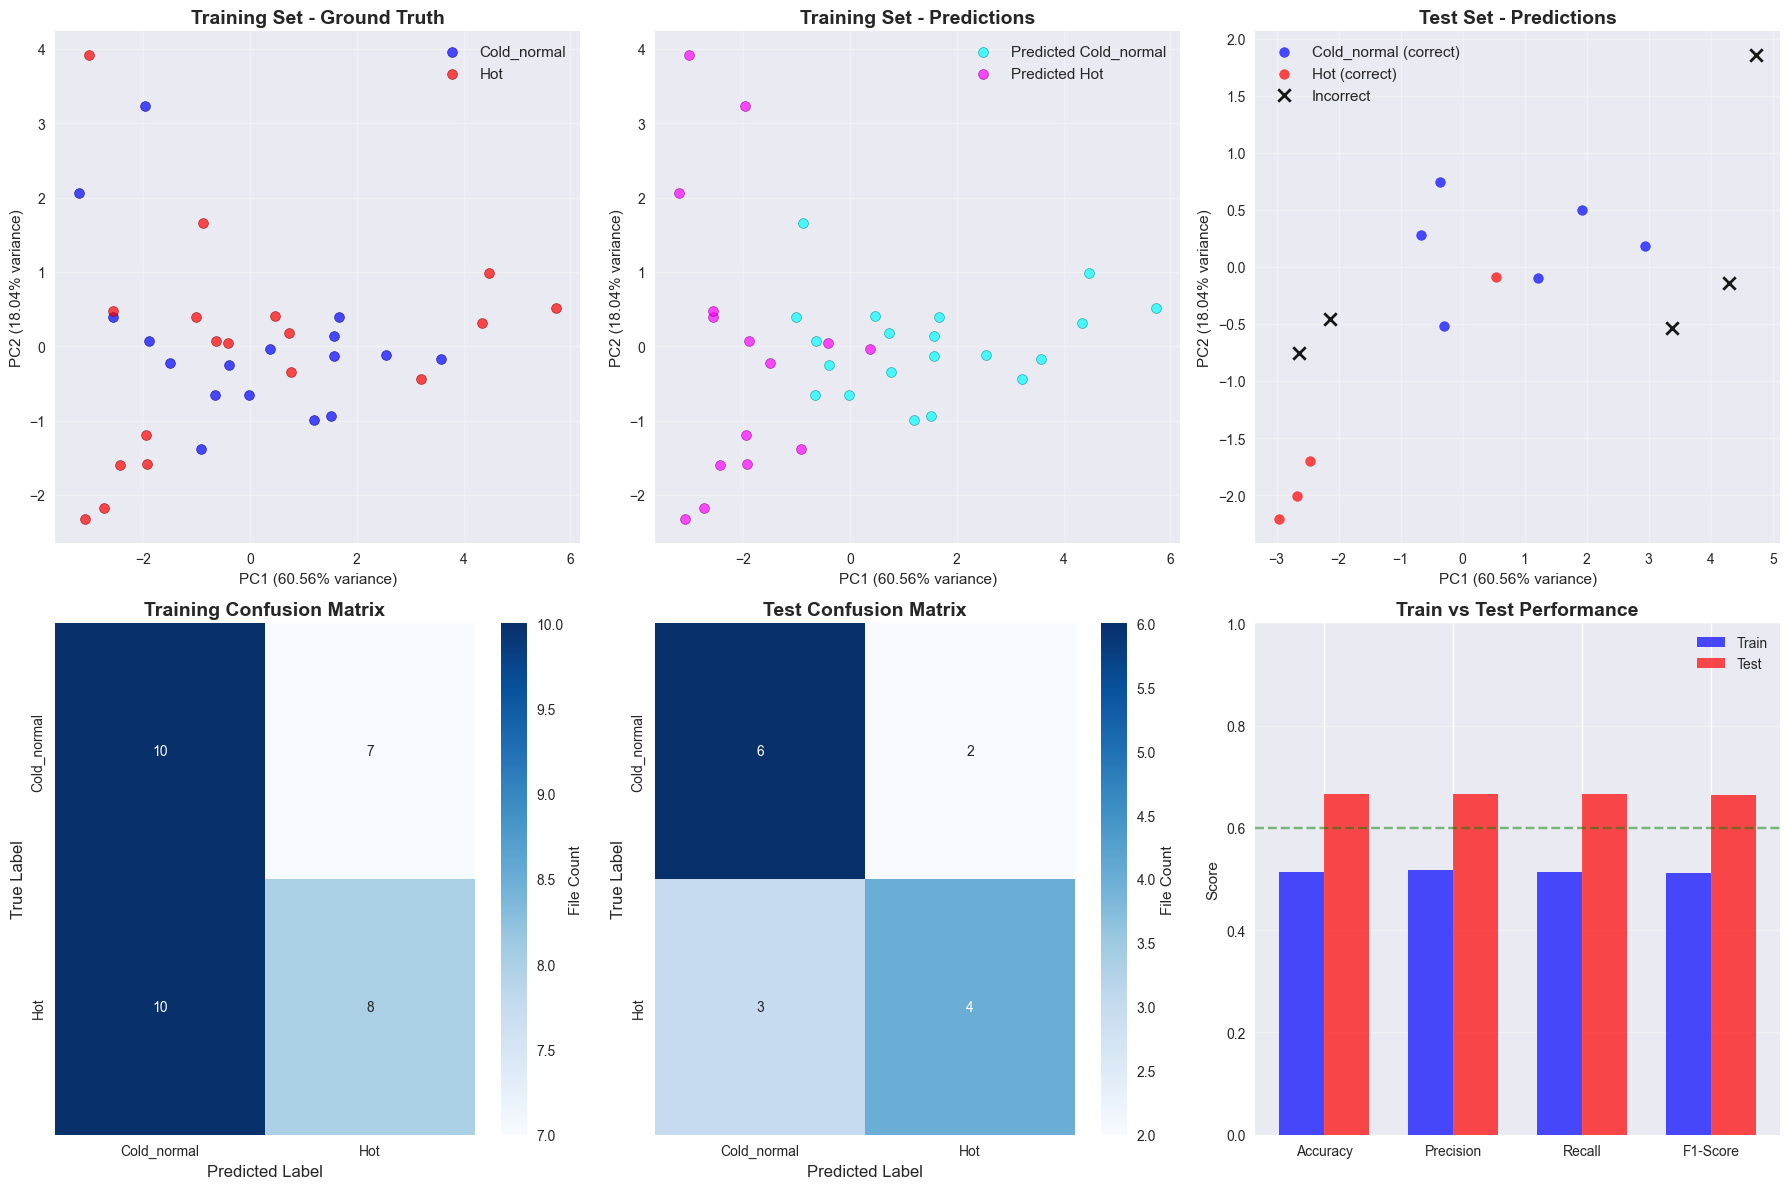


Visualization saved as 'gmm_classification_results.png'


In [25]:
# Prepare data for visualization
X_train_best = X_train[:, best_feature_indices]
X_test_best = X_test[:, best_feature_indices]
X_train_scaled = best_result['scaler'].transform(X_train_best)
X_test_scaled = best_result['scaler'].transform(X_test_best)

# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Training Set - Ground Truth
ax1 = axes[0, 0]
cold_mask_train = y_train == 'Cold_normal'
hot_mask_train = y_train == 'Hot'
ax1.scatter(X_train_pca[cold_mask_train, 0], X_train_pca[cold_mask_train, 1], 
           label='Cold_normal', alpha=0.7, s=50, color='blue', edgecolors='darkblue', linewidths=0.5)
ax1.scatter(X_train_pca[hot_mask_train, 0], X_train_pca[hot_mask_train, 1], 
           label='Hot', alpha=0.7, s=50, color='red', edgecolors='darkred', linewidths=0.5)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax1.set_title('Training Set - Ground Truth', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(alpha=0.3)

# 2. Training Set - Predictions
ax2 = axes[0, 1]
pred_cold_train = best_result['predictions'] == 'Cold_normal'
pred_hot_train = best_result['predictions'] == 'Hot'
ax2.scatter(X_train_pca[pred_cold_train, 0], X_train_pca[pred_cold_train, 1], 
           label='Predicted Cold_normal', alpha=0.7, s=50, color='cyan', edgecolors='darkcyan', linewidths=0.5)
ax2.scatter(X_train_pca[pred_hot_train, 0], X_train_pca[pred_hot_train, 1], 
           label='Predicted Hot', alpha=0.7, s=50, color='magenta', edgecolors='darkmagenta', linewidths=0.5)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax2.set_title('Training Set - Predictions', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=11)
ax2.grid(alpha=0.3)

# 3. Test Set - Correct vs Incorrect
ax3 = axes[0, 2]
cold_mask_test = y_test == 'Cold_normal'
hot_mask_test = y_test == 'Hot'
correct = (y_test == best_result['test_predictions'])
ax3.scatter(X_test_pca[correct & cold_mask_test, 0], X_test_pca[correct & cold_mask_test, 1], 
           label='Cold_normal (correct)', alpha=0.7, s=50, color='blue', marker='o')
ax3.scatter(X_test_pca[correct & hot_mask_test, 0], X_test_pca[correct & hot_mask_test, 1], 
           label='Hot (correct)', alpha=0.7, s=50, color='red', marker='o')
incorrect = ~correct
ax3.scatter(X_test_pca[incorrect, 0], X_test_pca[incorrect, 1], 
           label='Incorrect', alpha=0.9, s=80, color='black', marker='x', linewidths=2)
ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax3.set_title('Test Set - Predictions', fontsize=14, fontweight='bold')
ax3.legend(loc='best', fontsize=11)
ax3.grid(alpha=0.3)

# 4. Training Confusion Matrix
ax4 = axes[1, 0]
sns.heatmap(best_result['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=ax4,
            xticklabels=['Cold_normal', 'Hot'],
            yticklabels=['Cold_normal', 'Hot'],
            cbar_kws={'label': 'File Count'})
ax4.set_xlabel('Predicted Label', fontsize=12)
ax4.set_ylabel('True Label', fontsize=12)
ax4.set_title('Training Confusion Matrix', fontsize=14, fontweight='bold')

# 5. Test Confusion Matrix
ax5 = axes[1, 1]
sns.heatmap(best_result['test_confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=ax5,
            xticklabels=['Cold_normal', 'Hot'],
            yticklabels=['Cold_normal', 'Hot'],
            cbar_kws={'label': 'File Count'})
ax5.set_xlabel('Predicted Label', fontsize=12)
ax5.set_ylabel('True Label', fontsize=12)
ax5.set_title('Test Confusion Matrix', fontsize=14, fontweight='bold')

# 6. Performance Comparison
ax6 = axes[1, 2]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_scores = [
    best_result['train_accuracy'],
    best_result['train_precision'],
    best_result['train_recall'],
    best_result['train_f1']
]
test_scores = [
    best_result['test_accuracy'],
    best_result['test_precision'],
    best_result['test_recall'],
    best_result['test_f1']
]
x_pos = np.arange(len(metrics))
width = 0.35
ax6.bar(x_pos - width/2, train_scores, width, label='Train', color='blue', alpha=0.7)
ax6.bar(x_pos + width/2, test_scores, width, label='Test', color='red', alpha=0.7)
ax6.set_xticks(x_pos)
ax6.set_xticklabels(metrics)
ax6.set_ylabel('Score')
ax6.set_title('Train vs Test Performance', fontsize=14, fontweight='bold')
ax6.legend()
ax6.set_ylim([0, 1])
ax6.axhline(y=0.6, color='green', linestyle='--', alpha=0.5, label='60% threshold')
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('gmm_classification_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'gmm_classification_results.png'")


## 8. Save Best Model


In [26]:
import pickle
from datetime import datetime

print("="*80)
print("SAVING MODEL")
print("="*80)

model_package = {
    'gmm_model': best_result['gmm'],
    'scaler': best_result['scaler'],
    'cluster_to_label_mapping': best_result['cluster_mapping'],
    'feature_indices': best_feature_indices,
    'feature_names': [feature_names[i] for i in best_feature_indices],
    'aggregate_file_function': aggregate_file_to_features,
    'n_clusters': 2,
    'n_features': best_result['n_features'],
    'covariance_type': best_result['covariance_type'],
    'training_files': len(X_train),
    'test_files': len(X_test),
    'train_accuracy': best_result['train_accuracy'],
    'train_precision': best_result['train_precision'],
    'train_recall': best_result['train_recall'],
    'train_f1': best_result['train_f1'],
    'test_accuracy': best_result['test_accuracy'],
    'test_precision': best_result['test_precision'],
    'test_recall': best_result['test_recall'],
    'test_f1': best_result['test_f1'],
    'timestamp': datetime.now().isoformat()
}

# Save model
model_filename = 'gmm_temperature_classifier_best.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(model_package, f)

print(f"\nModel saved: {model_filename}")
print(f"\nModel details:")
print(f"  Features: {best_result['n_features']} selected features")
print(f"  Feature indices: {best_feature_indices}")
print(f"  Covariance type: {best_result['covariance_type']}")
print(f"  Training accuracy: {best_result['train_accuracy']*100:.2f}%")
print(f"  Test accuracy: {best_result['test_accuracy']*100:.2f}%")
print(f"\n✓ Model saved successfully!")


SAVING MODEL

Model saved: gmm_temperature_classifier_best.pkl

Model details:
  Features: 9 selected features
  Feature indices: [20, 21, 18, 19, 17, 0, 26, 24, 14]
  Covariance type: diag
  Training accuracy: 51.43%
  Test accuracy: 66.67%

✓ Model saved successfully!


## 9. Summary


In [27]:
print("="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"\nDataset:")
print(f"  Total files: {len(X)}")
print(f"  Training: {len(X_train)} files (70%)")
print(f"  Test: {len(X_test)} files (30%)")

print(f"\nModel Configuration:")
print(f"  Algorithm: Gaussian Mixture Model (GMM)")
print(f"  Components: 2 (Cold_normal, Hot)")
print(f"  Covariance type: {best_result['covariance_type']}")
print(f"  Features: {best_result['n_features']} (selected via Mutual Information)")

print(f"\nPerformance:")
print(f"  Training Accuracy: {best_result['train_accuracy']*100:.2f}%")
print(f"  Test Accuracy: {best_result['test_accuracy']*100:.2f}%")
print(f"  Test F1-Score: {best_result['test_f1']:.4f}")

print(f"\nOutputs:")
print(f"  Model file: gmm_temperature_classifier_best.pkl")
print(f"  Visualization: gmm_classification_results.png")

if best_result['test_accuracy'] >= 0.60:
    print(f"\n" + "="*80)
    print("✓ SUCCESS: Test accuracy meets 60% threshold!")
    print("="*80)
else:
    print(f"\n" + "="*80)
    print("⚠ WARNING: Test accuracy below 60% threshold")
    print("="*80)


FINAL SUMMARY

Dataset:
  Total files: 50
  Training: 35 files (70%)
  Test: 15 files (30%)

Model Configuration:
  Algorithm: Gaussian Mixture Model (GMM)
  Components: 2 (Cold_normal, Hot)
  Covariance type: diag
  Features: 9 (selected via Mutual Information)

Performance:
  Training Accuracy: 51.43%
  Test Accuracy: 66.67%
  Test F1-Score: 0.6637

Outputs:
  Model file: gmm_temperature_classifier_best.pkl
  Visualization: gmm_classification_results.png

✓ SUCCESS: Test accuracy meets 60% threshold!


In [28]:
# End of notebook
print("Notebook execution complete!")


Notebook execution complete!


---
**End of Notebook**


<!-- Duplicate cell removed -->
